In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline


In [35]:
# Read and preprocess data
df1 = pd.read_csv('../Shaoling/track_lyrics_1.csv')
df2 = pd.read_csv('../Shaoling/track_lyrics_2.csv')
df = pd.read_csv('Billboard Data/Billboard_with_Spotify_features.csv')
bb = pd.read_csv('Billboard Data/billboard_2014_to_current.csv')
# find tracks that are unique on billboard
tracks = df.title.unique()
billboard_lyrics = df1.loc[df1.track_name.isin(tracks)].append(df2.loc[df2.track_name.isin(tracks)])
# selected features
features = [
 'title',
 'Spotify_ID',
 'Spotify_Popularity',
 'Is_Explicit',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'valence']
billboard_lyrics.head()

,Unnamed: 0,track_name,artist_name,lyrics
63,63,Own It,2 Chainz & Wiz Khalifa,\n\n[Intro: Wiz Khalifa & 2 Chainz]\nIt's Youn...
75,75,S&M,Ed Sheeran,\n\n[Verse 1]\nThe club isn't the best place t...
127,127,Infinite,Eminem,\n\n[Produced by Mr. Porter & Jeff Bass]\n\n[I...
135,135,Faded,Alan Walker,\n\n[Verse 1]\nYou were the shadow to my light...
161,161,Girls,Maroon 5,"\n\n[Verse 1: Adam Levine]\nSpent 24 hours, I ..."


In [3]:
# drop duplicates items
df = df[features].drop_duplicates()
# unused columns
billboard_lyrics.drop('Unnamed: 0',axis = 1,
                     inplace = True)

positive_class = pd.merge(df,billboard_lyrics,left_on='title',
        right_on = 'track_name')
positive_class['Label'] = 1

In [ ]:
negative_class = pd.read_csv('Billboard Data/tracks_with_audio_features.csv')
# negative class are from different API calling, so column name is different
negative_class.rename({'id':'Spotify_ID',
                       'popularity':'Spotify_Popularity',
                       'name':'title',
                      'release_date':'Spotify_release_Date',
                      'explicit':'Is_Explicit'},axis = 1,
                     inplace = True)

negative_class = negative_class[features]
# to make it accurate, drop the duplicate items in this dataset
# since audio features should not be duplicated with other id

temp = pd.merge(negative_class,df1[['track_name','lyrics']],
        left_on = 'title',
        right_on = 'track_name')
songs_wrong = (temp.title.value_counts().loc[temp.title.value_counts() >= 2]).index
print(temp.shape)
temp = temp.loc[~temp.title.isin(songs_wrong)]
print(temp.shape)

negative_class = temp
negative_class['Label'] = 0

In [4]:
import gc
del temp
del df1
del df2
del bb
gc.collect()

14

# Simple text classifier for tracks

In [12]:
model_data = positive_class[['Spotify_ID','lyrics','Label']]\
.append(negative_class[['Spotify_ID','lyrics','Label']].sample(n = positive_class.shape[0]))


In [13]:
model_data.Label.value_counts()



1    804
0    804
Name: Label, dtype: int64

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split



In [19]:
countVect = CountVectorizer(binary = True,stop_words='english',
                           ngram_range = (1,2))


In [36]:
model_data['lyrics'] = [str(i) for i in model_data['lyrics']]

In [45]:
model_data['lyrics'] = model_data['lyrics'].str.replace('\n',' ')

In [46]:
X = model_data.drop(['Label','Spotify_ID'],1)
Y = model_data['Label']
X_train, X_test, y_train, y_test = train_test_split(X,Y)

In [47]:
type(X_train.iloc[0,0])

str

In [51]:
X_train.head()

,lyrics
26,[Chorus: 2 Chainz & Drake] I love bad bitche...
422,[Part 1: Yoncé] [Intro] Let me hear you say...
7548,So this was supposed to be a plain and simpl...
707,I really hope I can do it 'Cause they’re all...
12680,"[Hook: Shneezin]: Wer, wer macht den Song? K..."


In [62]:
X_vect = countVect.fit_transform(X_train.lyrics.tolist()).toarray()

In [63]:
X_vect_test = countVect.transform(X_test.lyrics.tolist()).toarray()

In [57]:
X_vect = pd.DataFrame(X_vect,
                      columns = countVect.get_feature_names())

In [65]:
X_vect_test = pd.DataFrame(X_vect_test,
                          columns = countVect.get_feature_names())

In [88]:
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

### Model fitting
BernoulliNB seems like overfit data, which gives super high recall but poor accuracy + precision

Logitstic Regression did much better job in generalization.

In [90]:
bn = BernoulliNB(alpha=10)
bn = LogisticRegression()

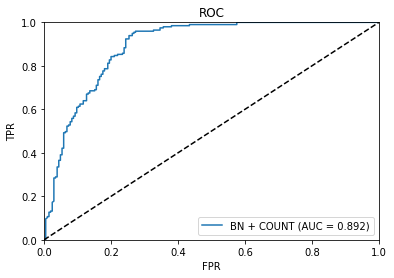

In [91]:
bn.fit(X_vect,y_train)
y_pred_prob = bn.predict_proba(X_vect_test)
y_pred = bn.predict(X_vect_test)
fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test,y_score=y_pred_prob[:,1])
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, label = 'BN + COUNT (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")


In [92]:
print(metrics.accuracy_score(y_pred=y_pred,y_true=y_test))
print(metrics.precision_score(y_pred=y_pred,y_true=y_test))
print(metrics.recall_score(y_pred=y_pred,y_true=y_test))
metrics.confusion_matrix(y_pred=y_pred,y_true=y_test,
                        labels =[1,0])

0.8233830845771144
0.7787610619469026
0.8934010152284264


array([[176,  21],
       [ 50, 155]])